<a href="https://colab.research.google.com/github/yrzaa/turbo-journey/blob/master/speech_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, \
    LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import librosa.display


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
from google.colab import drive
ROOT = "/content/drive"     # default location for the drive
print(ROOT)
drive.mount(ROOT)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/My Drive/data/free-spoken-digit-dataset-master/

/content/drive/My Drive/data/free-spoken-digit-dataset-master


DATA_DIR is the path, here on google drive

In [0]:
DATA_DIR = '/content/drive/My Drive/data/free-spoken-digit-dataset-master/recordings/'

In [0]:
random_file = rn.choice(os.listdir(DATA_DIR))

In [7]:
wav, sr = librosa.load(DATA_DIR + random_file)
print('sr:', sr)
print ('wav shape:', wav.shape)
print ('length:', wav.shape[0]/float(sr), 'secs')

sr: 22050
wav shape: (11279,)
length: 0.5115192743764172 secs


# Processing data
Converting to mfcc

In [8]:
test_speaker = 'theo'
train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))


for fname in os.listdir(DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        struct = fname.split('_')
        digit = struct[0]
        speaker = struct[1]
        wav, sr = librosa.load(DATA_DIR + fname)

        mfcc = librosa.feature.mfcc(wav)
        padded_mfcc = pad2d(mfcc,40)
        if speaker == test_speaker:
            test_mfccs.append(padded_mfcc)
            test_y.append(digit)
        else:
            train_mfccs.append(padded_mfcc)
            train_y.append(digit)
    except Exception as e:
        print (fname, e)
        raise
    


train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))


print ('train_mfccs:', train_mfccs.shape)
print ('train_y:', train_y.shape)

print

print ('test_mfccs:', test_mfccs.shape)
print ('test_y:', test_y.shape)



train_mfccs: (1500, 20, 40)
train_y: (1500, 10)
test_mfccs: (500, 20, 40)
test_y: (500, 10)


#Model

In [33]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print ('train X shape:', train_X_ex.shape)
print ('test X shape:', test_X_ex.shape)

train X shape: (1500, 20, 40, 1)
test X shape: (500, 20, 40, 1)


In [34]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4, 4))(m)
# m = Conv2D(128, kernel_size=(2, 2), activation='relu')(ip)
# m = MaxPooling2D(pool_size=(2, 2))(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(10, activation='softmax')(m)

model = Model(input=ip, output=op)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 20, 40, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 37, 64)        1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 9, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                73760     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 75,178
Trainable params: 75,178
Non-trainable params: 0
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mc = ModelCheckpoint('best.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(train_X_ex,
          train_y,
          epochs=1000,
          batch_size=32,
          verbose=0,
          validation_data=(test_X_ex, test_y),
          callbacks=[mc])


Epoch 00001: val_acc improved from -inf to 0.10000, saving model to best.hdf5

Epoch 00002: val_acc improved from 0.10000 to 0.11200, saving model to best.hdf5

Epoch 00003: val_acc improved from 0.11200 to 0.16400, saving model to best.hdf5

Epoch 00004: val_acc improved from 0.16400 to 0.29400, saving model to best.hdf5

Epoch 00005: val_acc improved from 0.29400 to 0.29800, saving model to best.hdf5

Epoch 00006: val_acc improved from 0.29800 to 0.31600, saving model to best.hdf5

Epoch 00007: val_acc did not improve from 0.31600

Epoch 00008: val_acc improved from 0.31600 to 0.38000, saving model to best.hdf5

Epoch 00009: val_acc improved from 0.38000 to 0.39000, saving model to best.hdf5

Epoch 00010: val_acc improved from 0.39000 to 0.42400, saving model to best.hdf5

Epoch 00011: val_acc improved from 0.42400 to 0.44400, saving model to best.hdf5

Epoch 00012: val_acc improved from 0.44400 to 0.47200, saving model to best.hdf5

Epoch 00013: val_acc did not improve from 0.47200

# Results:

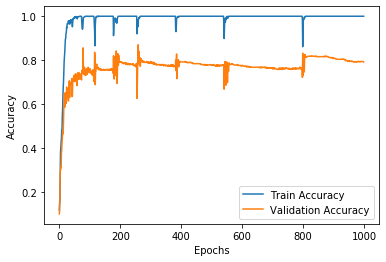

In [36]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [37]:
saved_model = load_model('best.hdf5')
# evaluate the model
train_ac = saved_model.evaluate(train_X_ex, train_y, verbose=0)
test_ac = saved_model.evaluate(test_X_ex, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_ac[1], test_ac[1]))

Train: 0.985, Test: 0.870
